
# Exploring Long-term Stability of Planetary Systems with New Numerical Tools

Hanno Rein<br/>
Daniel Tamayo 

*University of Toronto at Scarborough*

1. Long-term simulations of the Solar System
2. Reproducible sience with the SimulationArchive
3. Truly time symmetric integrators with JANUS

In [1]:
import rebound

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import ipywidgets
import warnings; warnings.filterwarnings("ignore")
from ctypes import pointer
from IPython.display import display

Download data for two simulations (one stable, one unstable) from zenodo:

In [2]:
import urllib.request
for file in ["restart_0052.bin","restart_0124.bin"]:
    #urllib.request.urlretrieve('https://zenodo.org/record/291988/files/'+file, file);
    pass # already downloaded

### Solar System 
* Only possible approach: perturbation theory
* In low order, leads to stability
* First direct numerical simulations by Laskar & Gastineau (Nature 2009)
* Need  $\sim10^{12}$ timesteps, good integrator

* Each integration only a random sample
* Statistical analysis needed
* Solar System is only marginally stable
* Large eccentricity of Mercury possible
* 1% of simulations lead to collisional trajectories

In [3]:
sa = rebound.SimulationArchive("restart_0124.bin")
w = sa[0].getWidget(size=(500,250),scale=3.)
display(w)
times = np.linspace(2*np.pi*7.5e9,2.*np.pi*7.740e9,5000)
for t in times:
    sim = sa.getSimulation(t)
    w.refresh(pointer(sim))

# Reproducible science with the SimulationArchive
Rein & Tamayo 2017, arxiv:1701.07423

Integrations of the Solar System are expensive. Take months to run. Need hundreds of realizations.
*** We want:***
* Share not only results, but also methods and data
* Open source, open science
* Reproducible experiment

Reproducible simulations have so far been impossible. ***Issues:***
* Source code/initial conditions not available
* System is chaotic, sensitive to floating point round-off at $10^{-16}$, need to reproduce everything bit-by-bit
* Initial conditions only available in ASCII table

Most (all?) public integrators are not machine independent!

* Ordering of operation 
  $$(x+y)+z\neq x+(y+z)$$
* Math functions 
  $$\sin_{\rm gcc}(x)\neq\sin_{\rm clang}(x)$$

* We ran hundreds of simulations of the Solar System
  * 10 Gyr, 6 day timestep
  * all planets, general relativistic corrections
* We use 
   * Open source code REBOUND
   * symplectic WHFast integrator, machine independent, high order symplectic correctors
   * Simulation Archive
* Archives are publicly available for everyone to explore doi:10.5281/zenodo.291988

In [4]:
file = "restart_0052.bin"

In [5]:
sa = rebound.SimulationArchive(file)
print(sa)

<rebound.SimulationArchive instance, snapshots=194422 particles=9 filesize=101102048 >


In [6]:
sim = sa.getSimulation(t=0.)
sim.getWidget(size=(500,250))

In [7]:
sim.integrate(5e4*2*np.pi)   # takes a few seconds
#sim.integrate(1e10*2*np.pi) # takes a few months

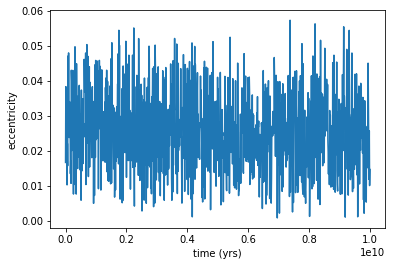

In [9]:
times = np.linspace(0,sa.tmax,1000)
ecc   = np.zeros(1000)
for i in range(1000):
    sim = sa.getSimulation(times[i])
    ecc[i] = sim.particles[3].e
    
f, ax = plt.subplots()
ax.set_xlabel("time (yrs)"); ax.set_ylabel("eccentricity")
ax.plot(times/2/np.pi,ecc);

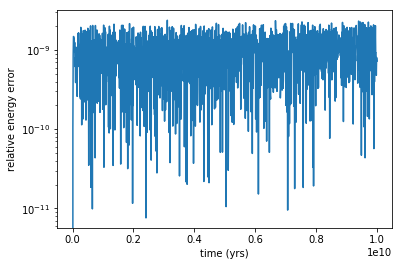

In [10]:
energy = np.zeros(1000)
for i in range(1000):
    sim = sa.getSimulation(times[i])
    energy[i] = sim.calculate_energy()

f, ax = plt.subplots()
ax.set_yscale("log"); ax.set_xlabel("time (yrs)"); ax.set_ylabel("relative energy error")
ax.plot(times/2/np.pi,np.abs((energy-energy[0])/energy[0]));

In [11]:
w = sa[0].getWidget(size=(500,250))
display(w)

In [12]:
for t in np.linspace(sa.tmin,sa.tmax,1000):
    sim = sa.getSimulation(t)
    w.refresh(pointer(sim))

In [ ]:
sa.getSimulation(6e9).t

In [ ]:
sa.getSimulation(6e9,mode="exact").t

### Advantages when using the SimulationArchive
* Reproducible simulations
* Machine independent
* Easy sharing of long simulations across the community

### Revolutionizing the way simulations are analyzed
* Can access any data at any time instantaneously/within seconds.
* Data is exact. Bit-by-bit. No interpolation or rounding.
* Never have to worry anymore about which data to output at which cadence!

### Secular resonances in the Solar System
Rein+ (2017, in prep)
<img src="resonant.png" width="60%"/>


### Instability due to Mercury-Jupiter resonance
Rein+ (2017, in prep)
<img src="mercuryjupiter.png" width="60%"/>



# Time reversibility
* Hamiltonian systems are time symmetric.
* Yet all of the integrators used for planetary dynamics are not!

In [ ]:
sim = rebound.Simulation()
sim.add(m=1)
for i in range(10):
    sim.add(m=1e-3, a=1+0.1*i,l=i, inc=0.01*i)
sim.move_to_com()
sim.integrator = "whfast"
sim.getWidget(scale=3, size=(500,200))

In [ ]:
sim.dt = 0.01  # forward
sim.integrate(200,exact_finish_time=0)

In [ ]:
sim.dt = -0.01 # backward
sim.integrate(0,exact_finish_time=0)

# JANUS

<img src="janus.jpg">

* Truly bit-wise reversible integrator
* Symplectic
* Order 2, 4, 6, 8 or 10
* Integrated in REBOUND
* Paper in preparation

In [ ]:
sim = rebound.Simulation()
sim.add(m=1)
for i in range(10): sim.add(m=1e-3, a=1+0.1*i,l=i, inc=0.01*i)
sim.move_to_com()
sim.integrator = "janus"
sim.getWidget(scale=3, size=(500,200))

In [ ]:
sim.dt = 0.01  # forward
sim.integrate(200,exact_finish_time=0)

In [ ]:
sim.dt = -0.01 # backward
sim.integrate(0,exact_finish_time=0)

In [ ]:
sim = rebound.Simulation()
sim.add(m=1)
for i in range(10): sim.add(m=1e-3, a=1+0.1*i,l=i, inc=0.01*i)
sim.move_to_com()
sim.integrator = "janus"
sim.getWidget(scale=3, size=(500,200))

In [ ]:
def f(t):
    sim.dt = 0.01 if t>sim.t else -0.01
    sim.integrate(t,exact_finish_time=0)    
ipywidgets.interact(f,t=ipywidgets.widgets.FloatSlider(min=0,max=300,step=1,value=0));

# Summary
* Statistical analysis of chaos in the Solar System
* SimulationArchive helps with explorative data analysis 
* SimulationArchive enables fully reproducible simulations
* JANUS, first truly time-symmetric N-body integrator<br /><br />

# REBOUND
* Modern open-source N-body package
* IAS15, WHFast, WHFastHelio, JANUS
* Variational equations, MEGNO
* Easy to use C / Python interface
* _Talk to me if you want to try out REBOUND!_